In [ ]:

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline 
from imblearn.under_sampling import TomekLinks



train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df = train_df.dropna(subset=['Revenue'])
train_df_clean = train_df.dropna(thresh=5).copy()

X = train_df_clean.drop('Revenue', axis=1, errors='ignore')
y = train_df_clean['Revenue'].astype(int)


num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# remove id
for col in ['ID', 'id']:
    if col in num_cols: num_cols.remove(col)
    if col in cat_cols: cat_cols.remove(col)


X[cat_cols] = X[cat_cols].astype(str)
test_df[cat_cols] = test_df[cat_cols].astype(str)

In [2]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_cols)
    ])

In [ ]:

tomek = TomekLinks(sampling_strategy='auto')


full_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor), 
    ('cleaner', tomek), 
    ('clf', XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        colsample_bytree=0.6, 
        random_state=42,
        gamma=0.2,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


# pipeline
full_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor), 
    ('tomek', TomekLinks()),               
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])


param_grid = {
    'clf__n_estimators': [100,300,400,500,600],
    'clf__max_depth': [3, 4, 5,6,7],
    'clf__learning_rate': [0.01,0.02, 0.05, 0.1,0.005],
    'clf__subsample': [0.5,0.7, 0.8, 0.9],
    'clf__colsample_bytree': [0.5,0.7, 0.8, 0.9],
    #'smote__k_neighbors': [3, 5, 7],  
    #'smote__sampling_strategy': [0.1,0.4,0.6] 
}
search = RandomizedSearchCV(full_pipeline, param_grid, n_iter=100, scoring='roc_auc', cv=6)
search.fit(X, y)
print(f"Best Params: {search.best_params_}")
print(f"Best Score: {search.best_score_}")
#Best Params: {'smote__sampling_strategy': 0.4, 'smote__k_neighbors': 7, 'clf__subsample': 0.8, 'clf__n_estimators': 400, 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.9}
#Best Score: 0.9311024165798357
#Best Params: {'clf__subsample': 0.7, 'clf__n_estimators': 600, 'clf__max_depth': 5, 'clf__learning_rate': 0.005, 'clf__colsample_bytree': 0.9}
#Best Score: 0.9300513805191225

In [ ]:
import joblib

joblib.dump(search.best_estimator_, 'xgbTomeklinks.joblib')

print("Model Saved")

Model Saved


In [ ]:
import pandas as pd


# dropping id
X_test = test_df[num_cols + cat_cols].copy()


empty_row_mask = X_test.isnull().all(axis=1)


for col in X_test.select_dtypes(include=['object', 'bool']).columns:
    X_test[col] = X_test[col].astype(str)



if hasattr(search, 'feature_names_in_'):
    X_test = X_test[search.feature_names_in_]


test_preds = search.predict(X_test)

-
submission = pd.DataFrame({
    'ID': test_df['ID'].astype(int) if 'ID' in test_df.columns else range(len(test_preds)),
    'Revenue': test_preds.astype(bool) 
})

# --- LOGIC OVERRIDE: Empty Rows = False ---
submission.loc[empty_row_mask, 'Revenue'] = False

# --- Save ---
submission.to_csv('file.csv', index=False)

print("--- SMOTE Submission Preview (Boolean) ---")
print(f"Empty rows found and forced to False: {empty_row_mask.sum()}")
print(f"Total Predicted Revenue (True): {submission['Revenue'].sum()}")
print(submission.head())

--- SMOTE Submission Preview (Boolean) ---
Empty rows found and forced to False: 0
Total Predicted Revenue (True): 314
   ID  Revenue
0   0     True
1   1     True
2   2    False
3   3    False
4   4    False


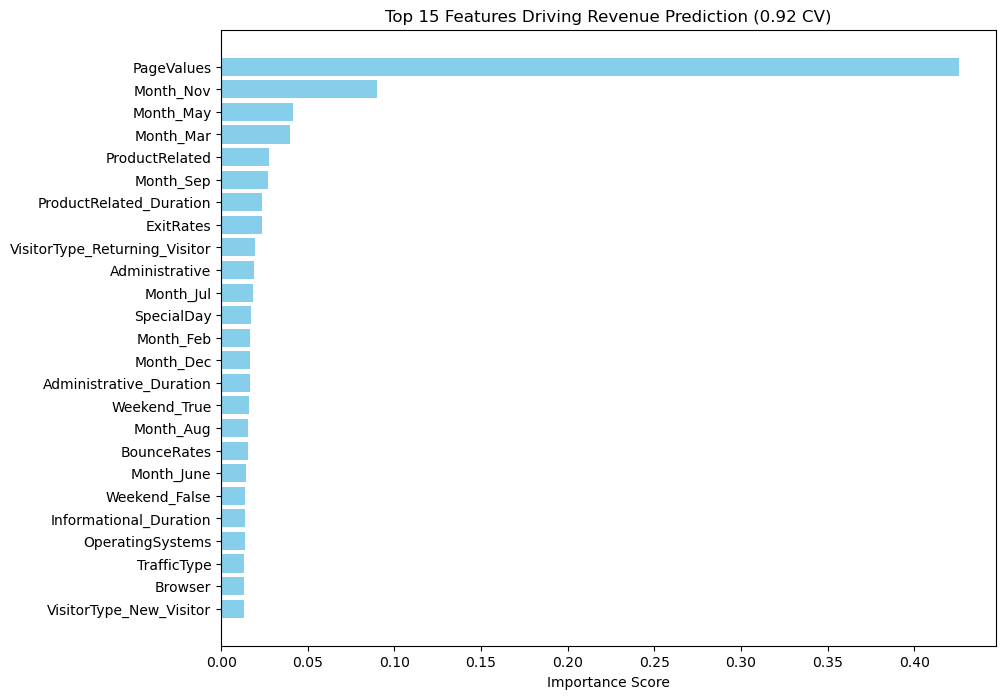

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

best_pipeline = search.best_estimator_
xgb_model = best_pipeline.named_steps['clf'] 


cat_feature_names = best_pipeline.named_steps['preprocessor']\
                    .transformers_[1][1]\
                    .named_steps['onehot']\
                    .get_feature_names_out(cat_cols)


all_feature_names = np.concatenate([num_cols, cat_feature_names])


importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:25][::-1], 
         feature_importance_df['Importance'][:25][::-1], 
         color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 15 Features Driving Revenue Prediction (0.92 CV)')
plt.show()